In [1]:
import numpy as np

s_size = 10000
s_min = 0.01
s_max = 3650

d_size = 90
d_min = 1
d_max = 10

r_size = 30
r_min = 0.7
r_max = 0.99

s_state = np.linspace(s_min, s_max, s_size)
d_state = np.linspace(d_min, d_max, d_size)
r_state = np.linspace(r_min, r_max, r_size)

s_state_mesh, d_state_mesh, r_state_mesh = np.meshgrid(
    s_state, d_state, r_state)

cost_matrix = np.zeros((d_size, s_size))
cost_matrix.fill(1000)
cost_matrix[:, -1] = 0
action_matrix = np.zeros((d_size, s_size))

w = [
    0.5888,
    1.4616,
    3.8226,
    14.1364,
    4.9214,
    1.0325,
    0.8731,
    0.0613,
    1.57,
    0.1395,
    0.988,
    2.212,
    0.0658,
    0.3439,
    1.3098,
    0.2837,
    2.7766,
]


def stability_after_success(s, d, r):
    return np.maximum(
        s_state[1],
        s
        * (
            1
            + np.exp(w[8])
            * (11 - d)
            * np.power(s, -w[9])
            * (np.exp((1 - r) * w[10]) - 1)
        ),
    )


def stability_after_failure(s, d, r):
    return np.maximum(
        s_min,
        np.minimum(
            w[11]
            * np.power(d, -w[12])
            * (np.power(s + 1, w[13]) - 1)
            * np.exp((1 - r) * w[14]),
            s,
        ),
    )


def mean_reversion(init, current):
    return (w[7] * init + (1 - w[7]) * current).clip(1, 10)


def difficulty_after_success(d):
    return mean_reversion(w[4], d)


def difficulty_after_failure(d):
    return mean_reversion(w[4], d + 2 * w[6])


# stability to index
def s2i(s): return np.clip(np.floor((s - s_min) /
                                    (s_max - s_min) * s_size).astype(int), 0, s_size - 1)
# difficulty to index


def d2i(d): return np.clip(np.floor((d - d_min) /
                                    (d_max - d_min) * d_size).astype(int), 0, d_size - 1)
# retention to index
def r2i(r): return np.clip(np.floor((r - r_min) /
                                    (r_max - r_min) * r_size).astype(int), 0, r_size - 1)


# indexes to cost
def i2c(s, d): return cost_matrix[d2i(d), s2i(s)]

In [2]:
import time

i = 0
diff = 10000
n_iter = 1000

success_cost = 1
failure_cost = 1

start = time.time()

while i < n_iter and diff > 1e-6*s_size*d_size:
    next_stability_after_success = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh)
    next_difficulty_after_success = difficulty_after_success(d_state_mesh)
    next_cost_after_success = i2c(
        next_stability_after_success, next_difficulty_after_success) + success_cost

    next_stability_after_failure = stability_after_failure(
        s_state_mesh, d_state_mesh, r_state_mesh)
    next_difficulty_after_failure = difficulty_after_failure(d_state_mesh)
    next_cost_after_failure = i2c(
        next_stability_after_failure, next_difficulty_after_failure) + failure_cost

    expected_cost = r_state_mesh * next_cost_after_success + \
        (1 - r_state_mesh) * next_cost_after_failure
    # update cost matrix
    optimal_cost = np.minimum(cost_matrix, expected_cost.min(axis=2))
    action_matrix = r_state[np.argmin(expected_cost, axis=2)]
    diff = cost_matrix.sum() - optimal_cost.sum()
    cost_matrix = optimal_cost
    if i % 10 == 0:
        print(
            f"iteration {i:>5}, diff {diff:.2f}, time {time.time() - start:.2f}s")
    i += 1

end = time.time()
print(f"Time: {end - start:.2f}s")

iteration     0, diff 596710067.00, time 2.60s
iteration    10, diff 4486864.53, time 25.79s
iteration    20, diff 2031602.62, time 49.26s
iteration    30, diff 1147377.75, time 72.80s
iteration    40, diff 666022.61, time 96.23s
iteration    50, diff 394325.24, time 119.66s
iteration    60, diff 235971.45, time 142.64s
iteration    70, diff 142147.93, time 164.78s
iteration    80, diff 86392.45, time 186.96s
iteration    90, diff 52748.78, time 208.74s
iteration   100, diff 32189.34, time 230.98s
iteration   110, diff 19719.37, time 253.55s
iteration   120, diff 12076.23, time 276.85s
iteration   130, diff 7402.76, time 300.55s
iteration   140, diff 4536.75, time 324.27s
iteration   150, diff 2780.78, time 347.63s
iteration   160, diff 1706.60, time 370.68s
iteration   170, diff 1047.58, time 393.23s
iteration   180, diff 642.70, time 416.54s
iteration   190, diff 394.21, time 439.63s
iteration   200, diff 241.76, time 462.41s
iteration   210, diff 148.26, time 484.32s
iteration   220

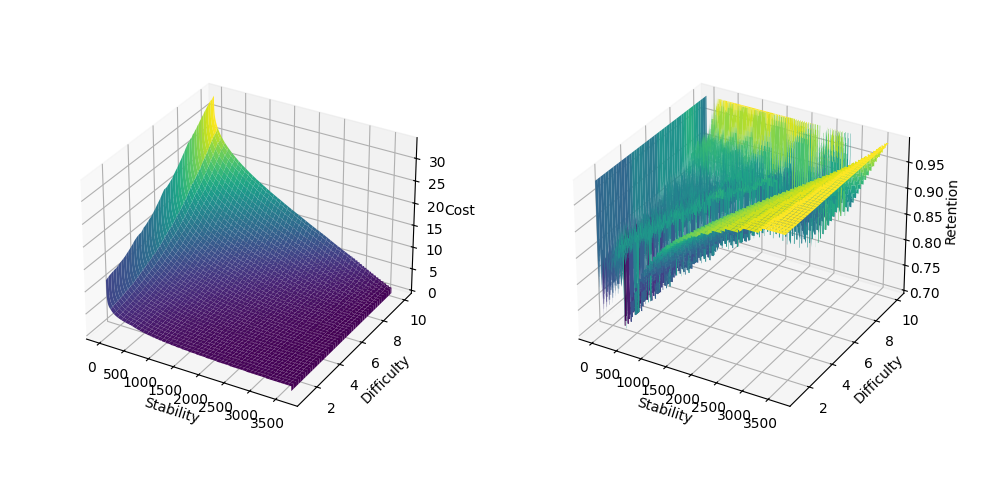

In [3]:
import matplotlib.pyplot as plt

s_state_mesh, d_state_mesh = np.meshgrid(s_state, d_state)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(s_state_mesh, d_state_mesh, cost_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Cost")
ax.set_box_aspect(None, zoom=0.8)
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(s_state_mesh, d_state_mesh, action_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Retention")
ax.set_box_aspect(None, zoom=0.8)
plt.tight_layout()
plt.show()